In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import copy
import matplotlib.pyplot as plt

# pandasの行を省略しない
pd.set_option('display.max_columns', None)

In [2]:
categorical_columns = ['curb_loc', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_common', 'spc_latin', 'nta',
       'nta_name', 'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist']

In [3]:
train_df = pd.read_csv('C:/python/signate/data/train.csv')
test_df = pd.read_csv('C:/python/signate/data/test.csv')

train_df = train_df.drop(['Unnamed: 0'], axis=1)
test_df = test_df.drop(['Unnamed: 0'], axis=1)
train_df.head()


,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,Quercus robur,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,Acer platanoides 'Crimson King',BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,Quercus robur,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,Gleditsia triacanthos var. inermis,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,Platanus x acerifolia,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


データはほとんどカテゴリカル
#### 思いついた精度向上案
- commonを個別名称として、latinの上を属名として利用する
- 地区が多すぎるので整理する

In [10]:
# train_dfのcolumnを取得
columns = test_df.columns


In [11]:
def cleansing(df):
    df['steward'] = df['steward'].replace({'None': 0, '1or2': 1, '3or4': 2, '4orMore': 3})
    return df

train_clean = cleansing(train_df)
test_clean = cleansing(test_df)

In [12]:
train_clean.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,Quercus robur,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,2.0,Helpful,NoDamage,Volunteer,NaN,crimson king maple,Acer platanoides 'Crimson King',BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,Quercus robur,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,Gleditsia triacanthos var. inermis,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,Platanus x acerifolia,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


In [13]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
# 一旦lightgbmで学習してみる
# label encodingでやってみる
y = train_df['health']
train_clean_drop = train_clean.drop(['health', 'created_at'], axis=1)
test_clean_drop = test_clean.drop(['created_at'], axis=1)

le = LabelEncoder()
for column in categorical_columns:
    train_clean_drop[column] = le.fit_transform(train_clean_drop[column])
    test_clean_drop[column] = le.fit_transform(test_clean_drop[column])

# trainとvalidに分割
X_train, X_test, y_train, y_test = train_test_split(train_clean_drop, y, test_size=0.2, random_state=0)
print(len(X_train))

# LightGBM用のデータセットに変換
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# LightGBMのハイパーパラメータの設定
params = {
  'objective':'multiclass', # 目的 : 多クラス分類
  'metric':{'multi_error'}, # 評価指標 : 不正解率(= 1-正解率)
  'num_class':3             # クラス数 : 3
}

# LightGBMモデルの学習
model = lgb.train(params, train_data,
                   num_boost_round=1000, valid_sets=[train_data, test_data], categorical_feature=categorical_columns)

# テストデータでの予測
y_pred = model.predict(X_test)
# Calculate accuracy score
# print("Accuracy:", f1_score(y_test, y_pred, average='macro'))


15987
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 19
[LightGBM] [Info] Start training from score -1.738591
[LightGBM] [Info] Start training from score -0.237206
[LightGBM] [Info] Start training from score -3.340937


In [14]:
train_clean_drop.head()

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,14,1,3,3,0,2,73,17,98,146,43,3,1082,3,23,52,1,2,22
1,5,1,1,1,1,2,73,56,7,52,11,1,297,0,4,18,23,55,14
2,26,1,3,3,1,2,28,17,98,169,1,4,1152,4,40,58,14,39,50
3,15,1,3,3,0,0,73,73,52,173,30,4,1174,4,40,58,14,39,50
4,23,1,3,3,1,2,27,28,81,87,28,0,113,2,27,9,20,47,8


In [ ]:
'''
# LightGBMモデルの学習
model = lgb.train(params, train_data,
                   num_boost_round=1000, valid_sets=[train_data, test_data], 
                    categorical_feature=categorical_columns, 
                    )

# テストデータでの予測
y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred, axis=1)
# Calculate accuracy score
print("Accuracy:", f1_score(y_test, y_pred_max, average='macro'))
'''

In [18]:
categorical_columns = ['curb_loc', 'health', 'sidewalk', 'user_type', 'problems', 'spc_common', 'spc_latin', 'nta',
       'nta_name', 'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist']

In [21]:
train_df.head()
train_df = train_df.fillna('None')

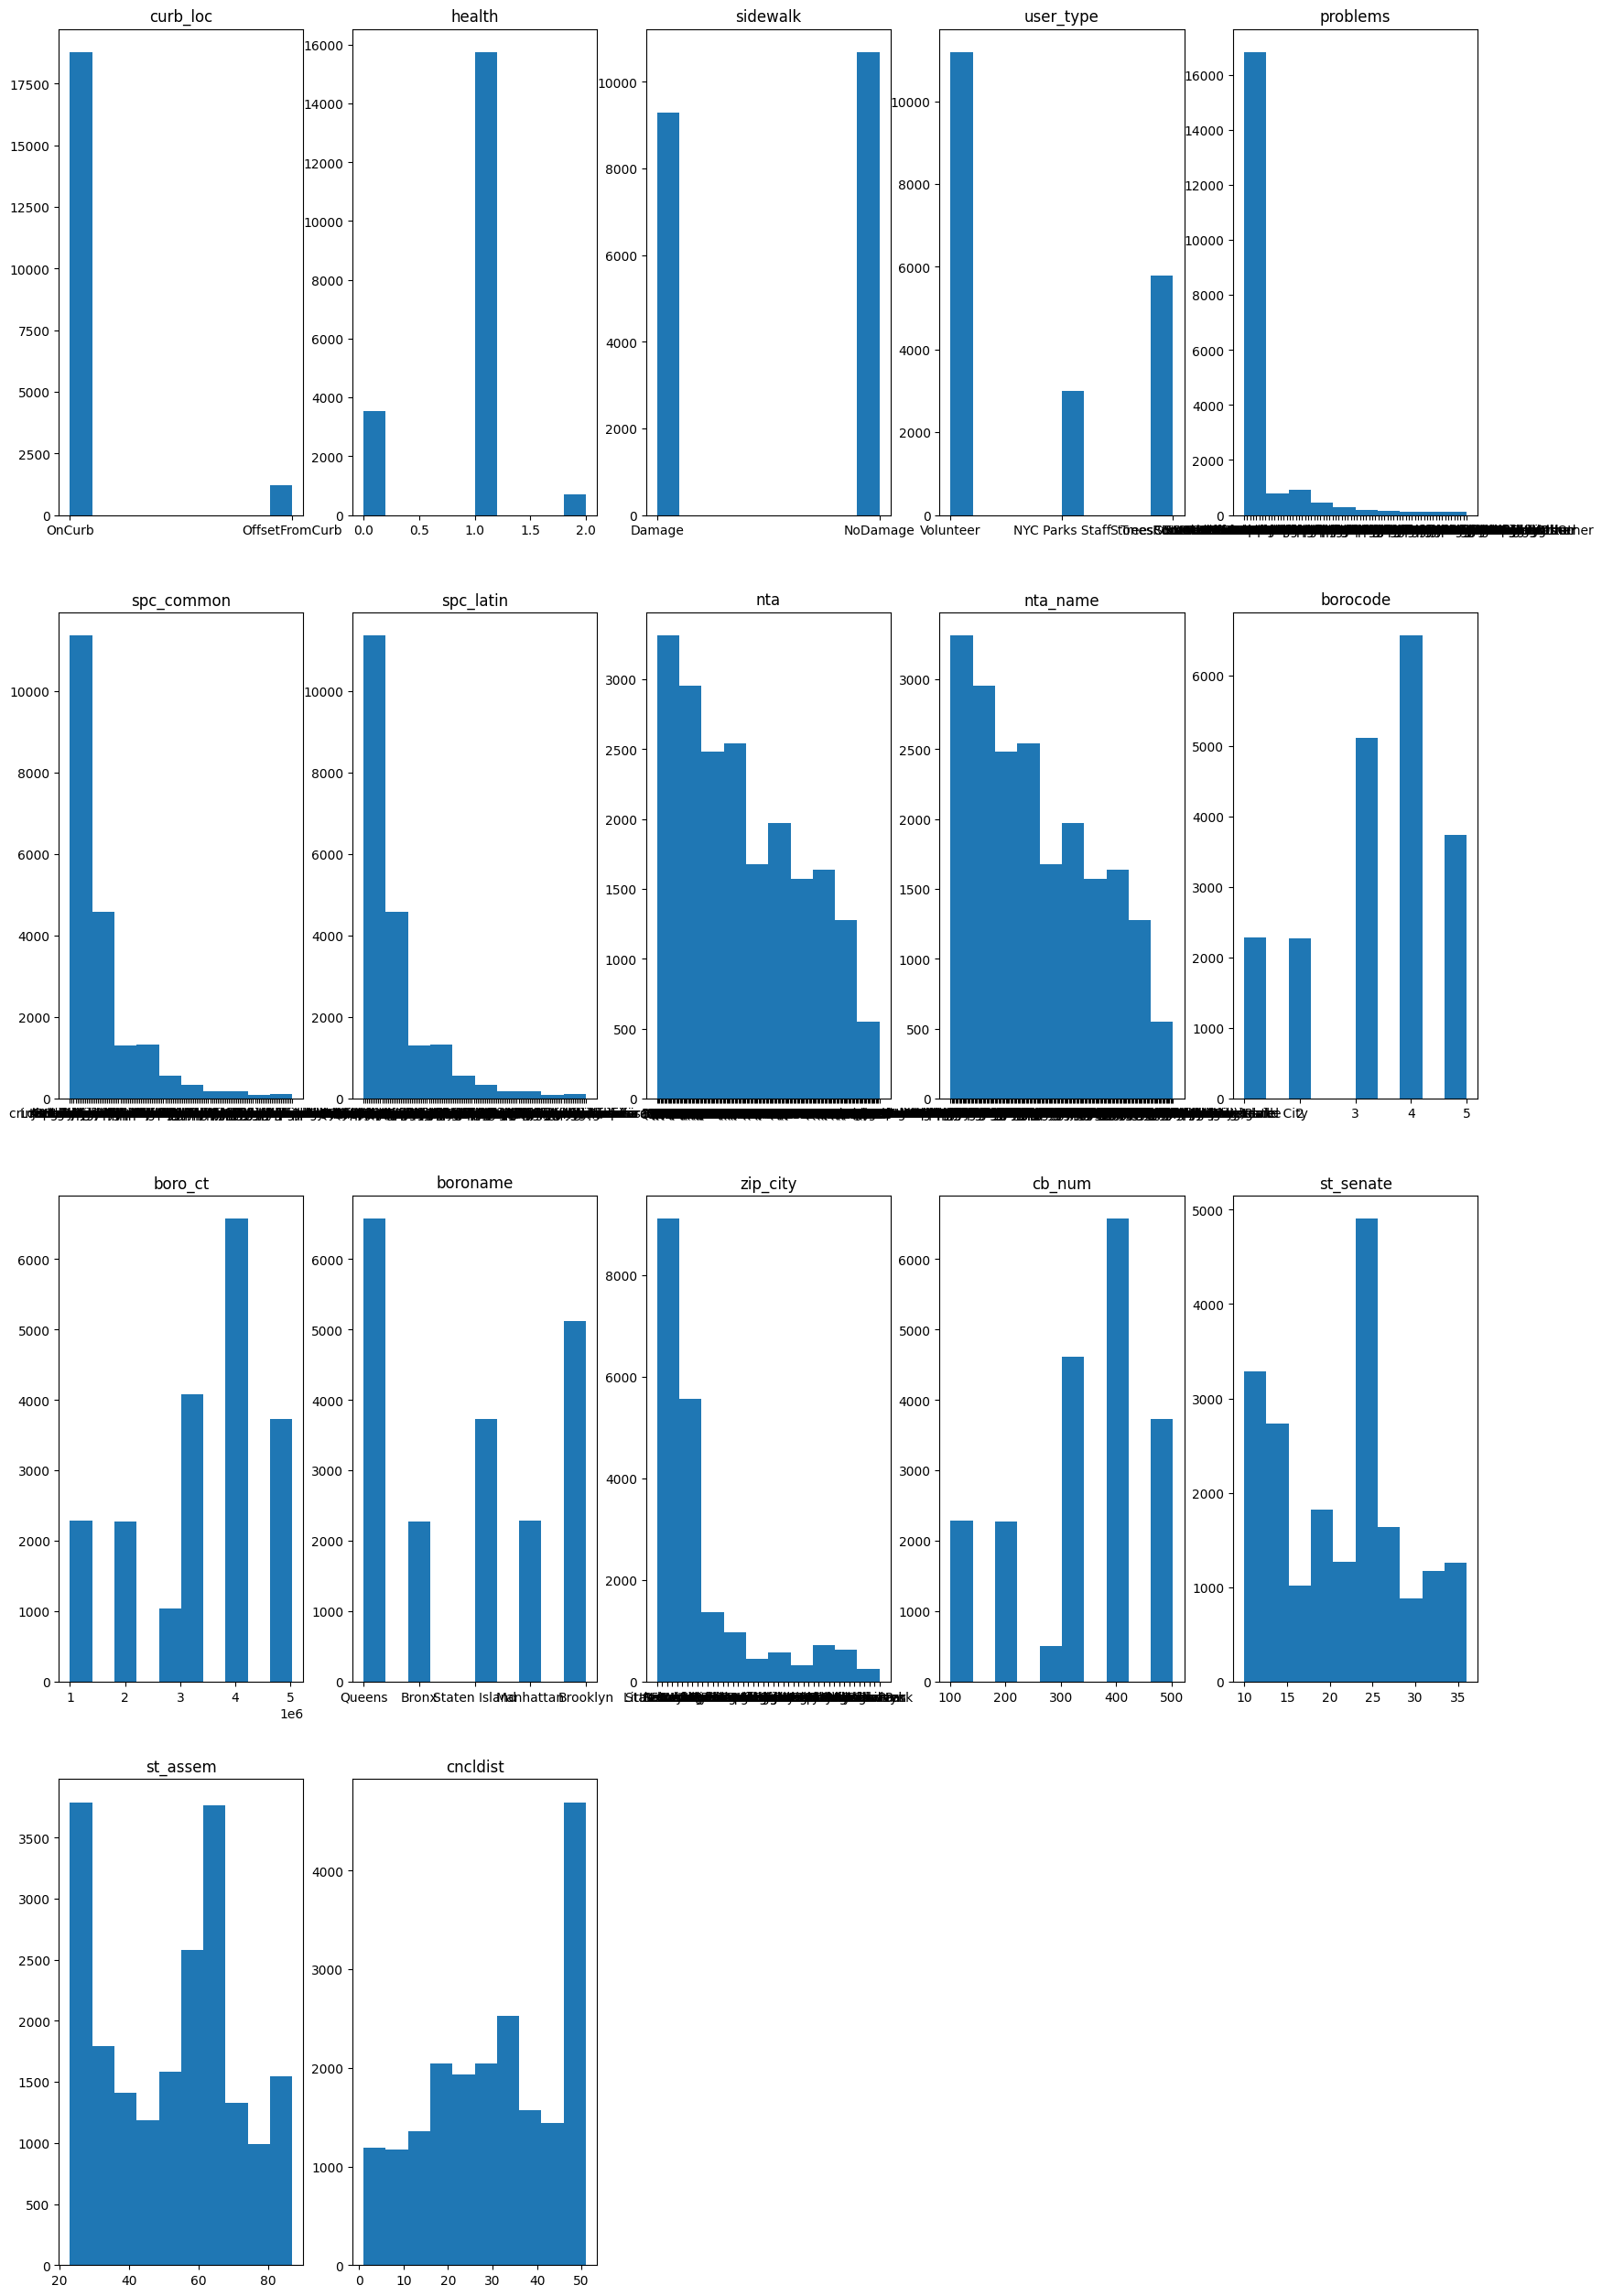

In [22]:
plt.figure(figsize=(20,40))
for i, col in enumerate(categorical_columns) :
    plt.subplot(5,5, i+1)
    plt.hist(train_df[col], bins=10)
    plt.title(col)
plt.show()
